In [1]:
import os
import cv2
import numpy as np
import glob
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns 

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


# Reading the Data

In [2]:
# importing the tram_csv
tram_df = pd.read_csv('tram_filenames.csv')
tram_df.drop(columns=tram_df.columns[0], axis=1, inplace=True)
tram_jpg = np.array(tram_df.filename_jpg)
tram_jpg

array(['rs02096.jpg', 'rs07844.jpg', 'rs06555.jpg', ..., 'rs08401.jpg',
       'rs06969.jpg', 'rs05051.jpg'], dtype=object)

In [3]:
i = 'rs02094.jpg'
if i in tram_jpg:
    print('yes')
else:
    print('nix')

nix


In [4]:
# Setting up the directory for the files 
path_masks = '/Users/arasdirekoglu/Documents/Daten/rs19_val/uint8/rs19_val/'
path_images = '/Users/arasdirekoglu/Documents/Daten/rs19_val/jpgs/rs19_val/' 

# Setting up a breaker for test run 
#breaker = 0

# Setting up empty lists for image & mask dataset 
image_dataset = []
mask_dataset = []

# Setting up the label of interest: 
label_of_interest = 8 #veg

# For loop 
for filename in os.listdir(path_images):
    if filename.endswith('.jpg') and filename in tram_jpg:
        image = Image.open(path_images+filename)
        image = np.array(image.resize((256, 256),3))
        mask = Image.open(path_masks+filename[:7]+'.png')
        mask = np.array(mask.resize((256,256),3))
        mask = np.expand_dims(mask, axis=2)
        for layer in range(len(mask[0,0,:])):
            #mask[:int(256/2),:,layer]=0
            mask[:,:,layer][mask[:,:,layer]!=label_of_interest]=0
            mask[:,:,layer][mask[:,:,layer]==label_of_interest]=1
        image_dataset.append(image)
        mask_dataset.append(mask)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

image:  (1318, 256, 256, 3)
mask:  (1318, 256, 256)
image:  (1318, 256, 256, 3)
mask:  (1318, 256, 256, 1)
unique labels in mask [0 1]


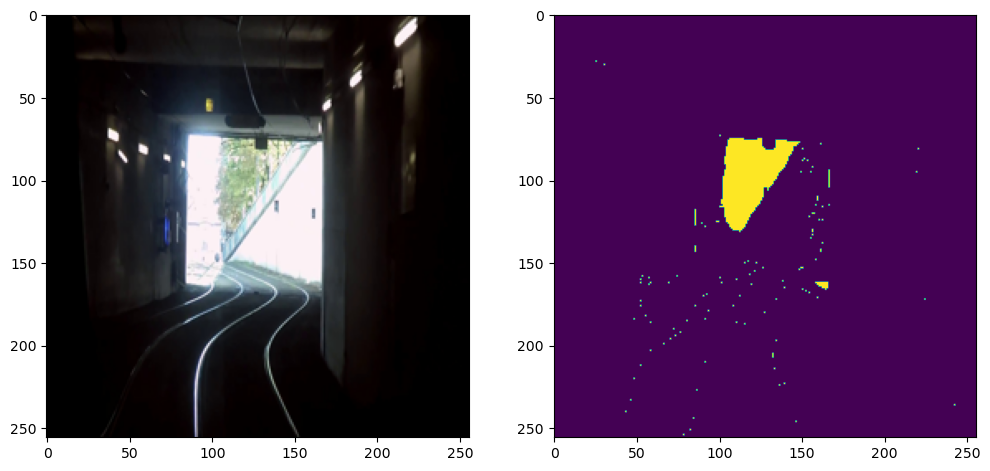

In [5]:
# Sanity check: Do images and masks match? 
image_number = np.random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()


# Split of Data

In [6]:
# split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


# Model

In [7]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [8]:
# define the model
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'accuracy']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

2022-11-15 15:57:46.408330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [9]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=15,
                        epochs=10,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/10
71/71 [==============================] - 351s 5s/step - loss: 0.2521 - iou_score: 0.5651 - f1-score: 0.7105 - accuracy: 0.9017 - val_loss: 0.4444 - val_iou_score: 0.5454 - val_f1-score: 0.7040 - val_accuracy: 0.8960
Epoch 2/10
71/71 [==============================] - 372s 5s/step - loss: 0.1639 - iou_score: 0.6674 - f1-score: 0.7994 - accuracy: 0.9384 - val_loss: 0.2448 - val_iou_score: 0.6144 - val_f1-score: 0.7601 - val_accuracy: 0.9208
Epoch 3/10
71/71 [==============================] - 340s 5s/step - loss: 0.1453 - iou_score: 0.6979 - f1-score: 0.8212 - accuracy: 0.9446 - val_loss: 0.2067 - val_iou_score: 0.6487 - val_f1-score: 0.7859 - val_accuracy: 0.9273
Epoch 4/10
71/71 [==============================] - 324s 5s/step - loss: 0.1377 - iou_score: 0.7155 - f1-score: 0.8332 - accuracy: 0.9482 - val_loss: 0.1716 - val_iou_score: 0.6883 - val_f1-score: 0.8145 - val_accuracy: 0.9370
Epoch 5/10
71/71 [==============================] - 323s 5s/step - loss: 0.1292 - iou_score:

1/1 [==============================] - 0s 169ms/step


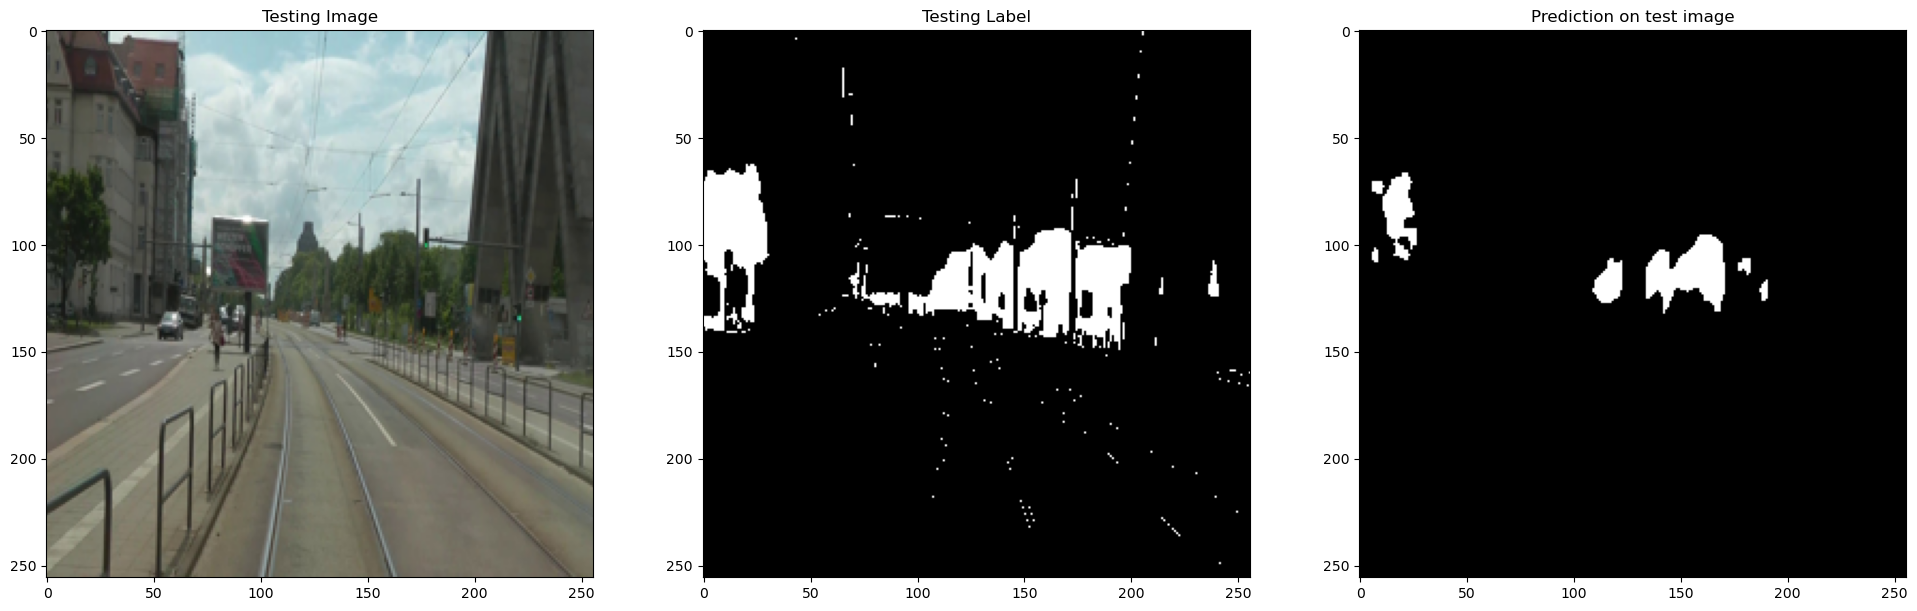

In [24]:
test_img_number = np.random.randint(0, len(X_test))
test_img = X_test[test_img_number]
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.99
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()